In [1]:
from sklearn.metrics import roc_auc_score
from bids import BIDSLayout
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import re
import os

import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
import seaborn as sns
import ptitprince as pt
import dabest

from util.tasks import process_SoAS, process_libet, process_dot_motion

In [2]:
# parse dataset
layout = BIDSLayout('data_bids_anon', validate = False)

# get subjects who completed everything through the SoA scale
sub_ids = layout.get_subjects(task = 'SoAScale')
sub_ids.sort(key = int)

/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/bids/layout/models.py:148: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


In [3]:
SoAS = process_SoAS(sub_ids, layout)
libet_conds, libet_subs = process_libet(sub_ids, layout)
dot_motion = process_dot_motion(sub_ids, layout)

Subject 326 removed from dot motion data for NaNs.


In [4]:
print('Number of subjects with data from all tasks: %d'%len(sub_ids))
print('Excluded from libet: %d'%libet_subs.exclude.sum())
print('Excluded from dot motion: %d'%dot_motion.exclude.sum())
print('Excluded from SoAS: %d'%SoAS.exclude.sum())

Number of subjects with data from all tasks: 195
Excluded from libet: 5
Excluded from dot motion: 12
Excluded from SoAS: 20


In [5]:
# remove outliers
libet_subs = libet_subs[~libet_subs.exclude]
dot_motion = dot_motion[~dot_motion.exclude]
SoAS = SoAS[~SoAS.exclude]

dot_motion['percent control threshold'] = 100*dot_motion['control threshold']

In [6]:
data = dabest.load(
    data = libet_conds, 
    x = ['type', 'target'], y = 'estimation error (ms)', 
    id_col = 'subject',
    paired = 'baseline',
    experiment = 'target',
    delta2 = True
)

ct = pd.DataFrame()
ct['control threshold'] = 100 * dot_motion['control threshold']
ct['type'] = 'percent'
lct = pd.DataFrame()
lct['control threshold'] = dot_motion['log control threshold']
lct['type'] = 'log'
ct_df = pd.concat([ct, lct])

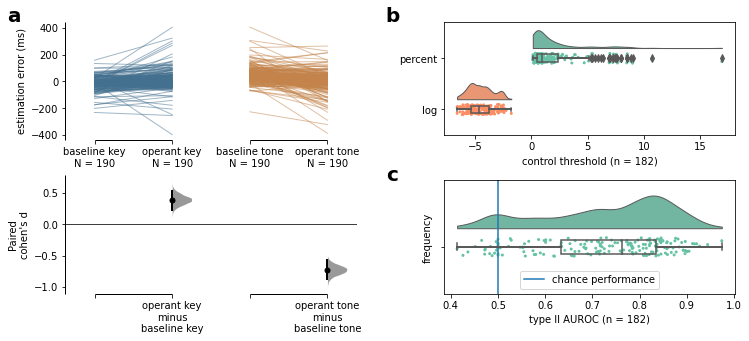

In [7]:
def add_label(ax, label):
    xmin, xmax = ax.get_xlim()
    xscale = xmax - xmin
    ymin, ymax = ax.get_ylim()
    yscale = ymax - ymin
    ax.text(
        xmin - .2 * xscale, ymax, 
        label, size = 20, weight = 'bold'
    )

fig = plt.figure(figsize = (12, 5))
gs = gridspec.GridSpec(2, 2, wspace = .3, hspace = .4)

# visualize intentional binding effect
left_ax = fig.add_subplot(gs[:, 0])
data.cohens_d.plot(es_marker_size = 5, ax = left_ax, show_delta2 = False)
left_ax.get_legend().remove()
add_label(left_ax, 'a')

# visualize distribution of dot motion measurements
ax = fig.add_subplot(gs[0, 1])
pt.RainCloud(x = 'type', y = 'control threshold', data = ct_df, orient = 'h', ax = ax)
ax.set_ylabel(None)
ax.set_xlabel('control threshold (n = %d)'%dot_motion.shape[0])
add_label(ax, 'b')

ax = fig.add_subplot(gs[1, 1])
pt.RainCloud(y = 'AUROC', data = dot_motion, orient = 'h', ax = ax)
ax.set_xlabel('type II AUROC (n = %d)'%dot_motion.shape[0])
ax.set_ylabel('frequency')
ax.axvline(.5, label = 'chance performance')
ax.legend(loc = 'lower center')
add_label(ax, 'c')

plt.savefig('Figure1.jpeg', dpi = 500)
plt.show()

In [8]:
# non-standard effect size estimates for intentional binding
data.mean_diff.results[['difference', 'ci', 'bca_low', 'bca_high']]

,difference,ci,bca_low,bca_high
0,27.850947,95,17.682661,39.249222
1,-57.888663,95,-71.267070,-46.574351


In [9]:
# standardized effect size estimates
data.cohens_d.results[['difference', 'ci', 'bca_low', 'bca_high']]

,difference,ci,bca_low,bca_high
0,0.393390,95,0.226628,0.535998
1,-0.721458,95,-0.869843,-0.575897


In [10]:
# merge sensorimotor measures
merged_sm = libet_subs.merge(dot_motion, how = 'outer', on = 'subject')
# now join agency scores
df = merged_sm.merge(SoAS, on = 'subject')

In [11]:
def sample_correlation_posterior(df, predictor, target):
    
    # drop NaNs and standardize 
    xy = df[[predictor, target]].dropna(inplace = False).to_numpy()
    xy = (xy - xy.mean(0))/xy.std(0) # standardize 

    with pm.Model() as model:
        mu = pm.Normal("mu", 0., 1., shape = 2)
        chol, corr, stds = pm.LKJCholeskyCov( # correlation matrix
            "chol", 
            n = 2, 
            eta = 2.0, 
            sd_dist = pm.Exponential.dist(1), 
            compute_corr = True
        )
        yd = pm.MvNormal("yd", mu = mu, chol = chol, observed = xy, shape = 2)
        trace = pm.sample(
            5000,
            tune = 2000,
            chains = 2,
            return_inferencedata = True, 
            random_seed = 0
        )
    
    # compile samples from across chains
    trc = trace.posterior.stack(draws = ("chain", "draw"))
    dist = trc['chol_corr'][0, 1].values
    
    # compile summary and diagnostic stats
    stats = pd.Series({
        'predictor': predictor,
        'target': target,
        'posterior mean': dist.mean(),
        'HDI lower': az.hdi(dist, .95)[0],
        'HDI upper': az.hdi(dist, .95)[1],
        'prob. negative': (dist < 0).mean(),
        'prob. positive': (dist > 0).mean(),
        'rhat': az.rhat(trace)['chol_corr'].values[0, 1],
        'n_subjects': xy.shape[0]
    })
    
    return dist, stats # return samples from correlation posterior

def df_from_res(res, predictor, target):
    df = pd.DataFrame({'correlation': res})
    df['predictor'] = predictor
    df['target'] = target
    return df

In [12]:
post_dists = []
post_stats = []
df['type II AUROC'] = df['AUROC']
for predictor in ('binding: key', 'binding: tone', 'log control threshold', 'type II AUROC'):
    for target in ('SoPA', 'SoNA'):
        post, stats = sample_correlation_posterior(df, predictor, target)
        post_df = df_from_res(post, predictor, target)
        post_dists.append(post_df)
        post_stats.append(stats)
post_df = pd.concat(post_dists)
post_stats = pd.DataFrame(post_stats)

/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


**Note:** The "RuntimeWarning: invalid value encountered in double_scalars" is happening because the code that computes $\hat{R}$ is computing it for each value in the $2 \times 2$ correlation matrix (`'chol_corr'`), not just the off-diagonal value we care about. Since the on-diagonal values are always $r = 1$ by definition, then `between_chain_variance` and `within_chain_variance` will always be 0, resulting in division by zero -- hence a numerical warning. In other words, the warning isn't a problem; this is expected behavior. 

In [13]:
post_stats

,predictor,target,posterior mean,HDI lower,HDI upper,prob. negative,prob. positive,rhat,n_subjects
0,binding: key,SoPA,-0.070511,-0.217340,0.081775,0.8227,0.1773,1.000638,170
1,binding: key,SoNA,0.071834,-0.080206,0.220857,0.1718,0.8282,0.999957,170
2,binding: tone,SoPA,-0.074893,-0.218634,0.075600,0.8375,0.1625,1.000036,170
3,binding: tone,SoNA,-0.081797,-0.230288,0.068428,0.8570,0.1430,0.999987,170
4,log control threshold,SoPA,0.013837,-0.138023,0.165431,0.4259,0.5741,1.000657,164
5,log control threshold,SoNA,0.165744,0.014739,0.309096,0.0168,0.9832,1.000038,164
6,type II AUROC,SoPA,0.114861,-0.033876,0.260863,0.0694,0.9306,0.999984,164
7,type II AUROC,SoNA,-0.310273,-0.447961,-0.179370,1.0000,0.0000,1.000079,164


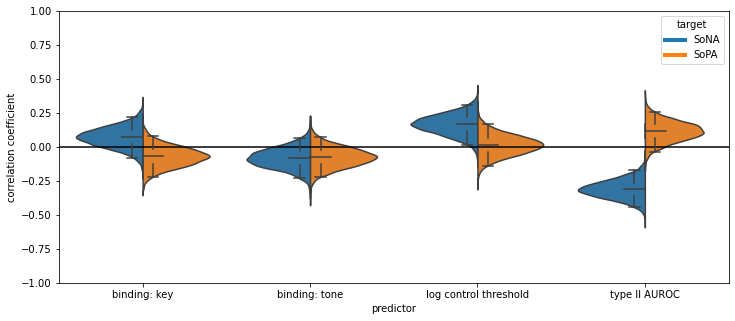

In [14]:
fig, ax = plt.subplots(figsize = (12, 5))

n_pred = post_df.predictor.unique().size
sns.violinplot(
    data = post_df,
    x = 'predictor', y = 'correlation', 
    hue = 'target', hue_order = ['SoNA', 'SoPA'],
    split = True, inner = None,
    ax = ax
)
ax.axhline(0., color = 'black', label = 'chance')
ax.set_ylim(-1, 1)

sns.boxplot(
    data = post_df,
    x = 'predictor', y = 'correlation', 
    hue = 'target', hue_order = ['SoNA', 'SoPA'],
    width = 1./n_pred, fliersize = 0., 
    whis = [2.5, 97.5], # make whiskers 95% credible interval 
    ax = ax
)
ax.legend_ = None

from matplotlib.lines import Line2D
colors = sns.color_palette()
legend_elements = [
    Line2D([0], [0], color = colors[0], lw = 4, label = 'SoNA'),
    Line2D([0], [0], color = colors[1], lw = 4, label = 'SoPA'),
]
ax.legend(handles = legend_elements, title = 'target')
ax.set_ylabel('correlation coefficient')

plt.savefig('Figure2.jpeg', dpi = 500)
plt.show()

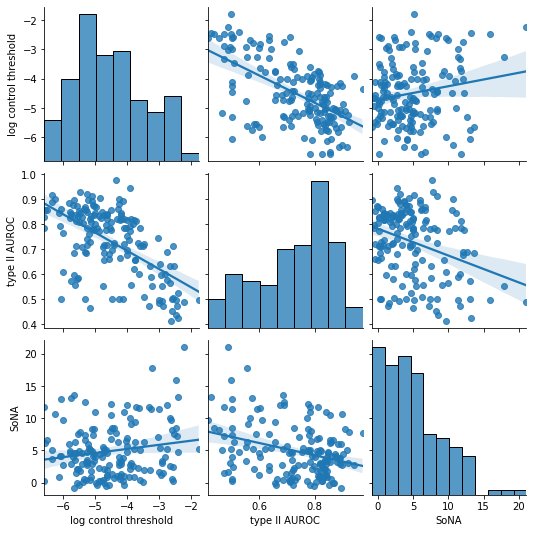

In [15]:
sns.pairplot(
    df, 
    vars = ['log control threshold', 'type II AUROC', 'SoNA'], 
    kind = 'reg',
)
plt.savefig('Figure3.jpeg', dpi = 500)

In [16]:
post, stats = sample_correlation_posterior(
    df, 'log control threshold', 'type II AUROC'
)
stats

/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


predictor         log control threshold
target                    type II AUROC
posterior mean                 -0.56948
HDI lower                     -0.668751
HDI upper                     -0.461268
prob. negative                      1.0
prob. positive                      0.0
rhat                           1.000666
n_subjects                          164
dtype: object

In [17]:
def mediation_model(x, m, y):
    with pm.Model() as model:
        x = pm.Data("x", x)
        y = pm.Data("y", y)
        m = pm.Data("m", m)

        # intercept priors
        im = pm.Normal("im", mu = 0, sigma = 1)
        iy = pm.Normal("iy", mu = 0, sigma = 1)
        # slope priors
        a = pm.Normal("a", mu = 0, sigma = 1)
        b = pm.Normal("b", mu = 0, sigma = 1)
        cprime = pm.Normal("direct effect", mu=0, sigma=1)
        # noise priors
        σm = pm.Exponential("σm", 1)
        σy = pm.Exponential("σy", 1)

        # likelihood
        pm.Normal("m_likehood", mu = im + a * x, sigma = σm, observed = m)
        pm.Normal("y_likehood", mu = iy + b * m + cprime * x, sigma = σy, observed = y)

        # calculate quantities of interest
        indirect_effect = pm.Deterministic("indirect effect", a * b)
        total_effect = pm.Deterministic("total effect", a * b + cprime)

    return model

In [18]:
def normalize(x):
    return (x - x.mean())/x.std()

_df = df[['log control threshold', 'type II AUROC', 'SoNA']].dropna(inplace = False)
model = mediation_model(
    x = normalize(_df['log control threshold']), 
    m = normalize(_df['type II AUROC']), 
    y = normalize(_df['SoNA'])
)

In [19]:
with model:
    result = pm.sample(
        5000,
        tune = 2000,
        chains = 2,
        target_accept = 0.9,
        random_seed = 0,
        return_inferencedata = True,
        idata_kwargs = {"dims": {"x": ["obs_id"], "m": ["obs_id"], "y": ["obs_id"]}},
    )

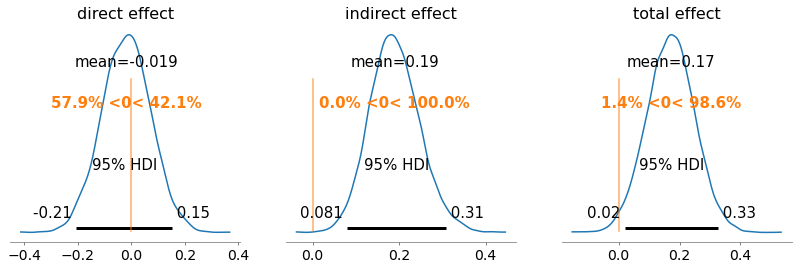

In [20]:
ax = az.plot_posterior(
    result,
    var_names = ["direct effect", "indirect effect", "total effect"],
    ref_val = 0,
    hdi_prob = 0.95,
    figsize = (14, 4),
)

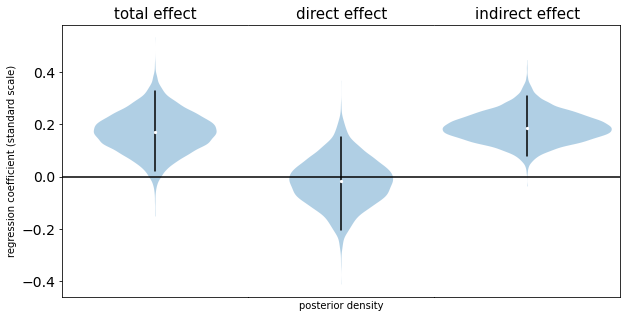

In [21]:
axs = az.plot_violin(
    result,
    var_names = ["total effect", "direct effect", "indirect effect"],
    hdi_prob = 0.95,
    figsize = (10, 5),
    quartiles = False
)
for ax in axs:
    ax.axhline(0., color = 'black')
axs[0].set_ylabel('regression coefficient (standard scale)')
axs[1].set_xlabel('posterior density')
plt.savefig('Figure4.jpeg', dpi = 500)
plt.show()

In [22]:
az.summary(
    result, 
    var_names = ["direct effect", "indirect effect", "total effect"], 
    hdi_prob = .95
)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
direct effect,-0.019,0.091,-0.206,0.153,0.001,0.001,11410.0,7902.0,1.0
indirect effect,0.190,0.058,0.081,0.308,0.001,0.000,11737.0,7789.0,1.0
total effect,0.171,0.078,0.020,0.327,0.001,0.001,12964.0,7896.0,1.0


In [23]:
trc = result.posterior.stack(draws = ("chain", "draw"))
direct = trc['direct effect'].values
indirect = trc['indirect effect'].values
diff = indirect - direct
print('Probability indirect > direct effect is %.03f'%(diff > 0).mean())

Probability indirect > direct effect is 0.946
